# Analysis: Visualizing Model Training <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Visualize-Training" data-toc-modified-id="Visualize-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualize Training</a></span></li></ul></div>

## Imports \& Config

In [1]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)

import pandas as pd
from itertools import cycle

import pickle, json
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

/home/zacharias/ProGraML


## Visualize Training

In [3]:
def get_all_runs(log_dir, subfolders=False, exclude=['test_only']):
    print(log_dir.name)
    assert subfolders == False, 'not implemented'
    logs = {}
    hyps = {}
    for file in log_dir.glob('*_log.json'):
        with open(file, 'r') as f:
            run_name = file.name.rsplit('_log.json')[0]
            # load hyps
            hyp_file = file.parent / (run_name + '_params.json')
            try:
                with open(hyp_file, 'r') as h:
                    hyp = json.load(h)
            except FileNotFoundError:
                hyp = ''
            
            hyps[run_name] = hyp
            
            # skip weird files
            if run_name[:2] == '._':
                continue

            print(run_name)
            
            log = pd.read_json(f, orient='records')
            
            # handle 'test_only' epochs later!
            if log['epoch'].values[0] == 'test_only':
                continue
            
            # flatten dataframe
            valid = pd.DataFrame(log.valid_results.tolist(), columns=['valid_loss', 'valid_acc', 'valid_speed'])
            train = pd.DataFrame(log.train_results.tolist(), columns=['train_loss', 'train_acc', 'train_speed'])
            if hasattr(log, 'test_results'):
                test = pd.DataFrame(log.test_results.tolist(), columns=['test_loss', 'test_acc', 'test_speed'])
                df = pd.concat([log.epoch, log.time, train, valid, test], axis=1)
            else:
                df = pd.concat([log.epoch, log.time, train, valid], axis=1)

            logs[run_name] = df
    return logs, hyps

In [4]:
def make_label(name, split, hyps, show_hyps=True):
    hyp = hyps[name]
    #assert hyp, print(name, hyp)
    hyp_str = ''
    if show_hyps and hyp:
        # add later: mean_aggr, pos_emb
        # sub{str(hyp.get('train_subset', [0, 100])) 
        hyp_str = f"lr{hyp['lr']:.5f}_bs{hyp['batch_size']:3d}" \
                  f"_lt{len(hyp['layer_timesteps'])}x{hyp['layer_timesteps'][0]}" \
                  f"_gsdrop{hyp['graph_state_dropout']:.1f}" \
                  f"_odrop{hyp['output_dropout']:.1f}" \
                  f"_ewdrop{hyp['edge_weight_dropout']:.1f}" \
                  f"_pos{hyp['position_embeddings']:1d}" \
                  f"_ntyp{hyp.get('use_node_types', False):1d}" \
                  f"_ebias{hyp['use_edge_bias']:1d}" \
                  f"_mean{hyp['msg_mean_aggregation']:1d}"
    return hyp_str + '__' + name + '__' + split

In [5]:
def annot_max(x,y, test_y, color='k', label=None, ax=None):
    xmax = x[np.argmax(np.array(y))]
    ymax = y.max()
    test_y = test_y[np.argmax(np.array(y))]
    text= "val acc {:.4f}, test acc {:.4f} @ ep {:d}".format(ymax, test_y, int(xmax))
    if label:
        text = text + '\n' + label
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3",
                      fc='w',
                      ec=color,
                      lw=0.72)
    arrowprops = dict(arrowstyle="->",
                    #connectionstyle="angle,angleA=0,angleB=60",
                    color=color)
    kw = dict(xycoords='data',
              textcoords='data',
              #textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props,
              ha="right",
              va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax + np.random.uniform(-xmax/1.5,xmax/2) , max((ymax - 0.951)*24 + 0.7, 0.91 + np.random.uniform(-0.01, 0.01))) , **kw)  # xytext=(xmax,0.90 + (np.random.rand() - 0.5) / 5)

In [6]:
def plot_logs(logs, hyps):
    plt.figure(figsize=(24, 12))
    #cycle_colors=iter(plt.cm.hsv(np.linspace(0,0.97,len(logs)))) #jet / hsv / rainbow
    cycle_colors = cycle(iter(plt.rcParams['axes.prop_cycle'].by_key()['color']))
    for name, log in logs.items():
        if log['valid_acc'].max() < 0.96:
            #continue
            pass
        c = next(cycle_colors) #next(color)

        plt.plot(log['epoch'], log['valid_acc'], label='_nolegend_', ls='dashed', c=c) # , label=make_label(name, 'valid')
        plt.plot(log['epoch'], log['train_acc'], label='_nolegend_', ls='dotted', c=c) # make_label(name, 'train')
        if hasattr(log, 'test_acc'):
            label = make_label(name, 'test', hyps)
            plt.plot(log['epoch'], log['test_acc'], label=label, c=c)
            annot_max(log['epoch'], log['valid_acc'], log['test_acc'], c, label=label.rsplit('__')[0] + '\n' + label.rsplit('__')[1])

    #plt.minorticks_on()
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.ylim((0.850, 1.0))
    plt.grid(which='major', axis='x', c='grey')
    plt.grid(which='minor', axis='y', c='silver', ls='--')
    plt.grid(which='major', axis='y', c='black')
    plt.minorticks_on()
    plt.legend(loc='lower left', prop={'family': 'monospace'})

    plt.show()

run_over_layer_timesteps
2020-01-23_04:44:49_poj003_24508
2020-01-23_04:42:19_poj002_24507
2020-01-23_05:33:53_poj004_24509
2020-01-23_04:41:44_poj001_24506
2020-01-23_04:40:57_poj000_24505


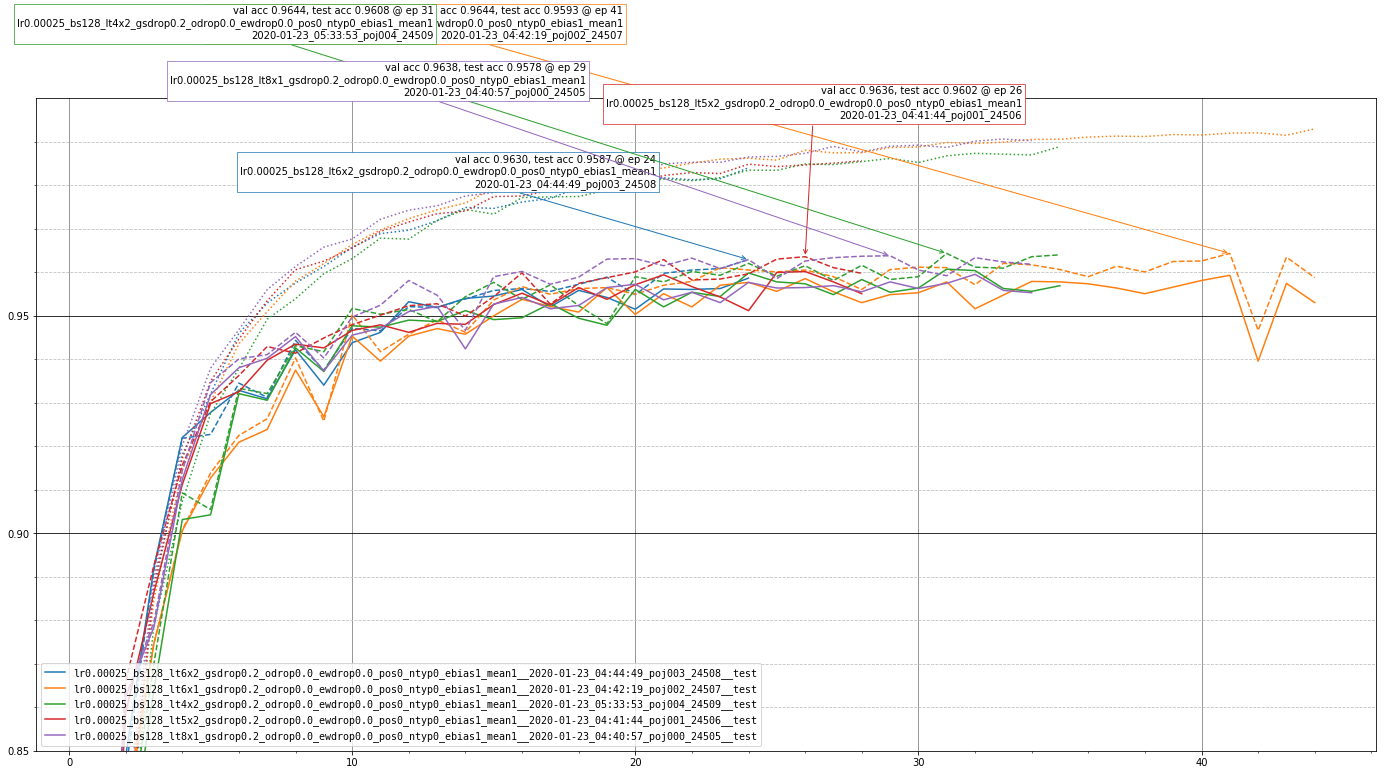

In [7]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
#sub = 'ault_logs_mirror/run_over_binary_choices/'
sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir)
plot_logs(logs, hyps)

run_over_binary_choices
2020-01-23_01:36:53_poj009_24498
2020-01-23_04:38:45_poj013_24502
2020-01-23_01:33:36_poj000_24489
2020-01-23_04:35:01_poj012_24501
2020-01-23_01:35:34_poj001_24490
2020-01-23_01:35:52_poj004_24493
2020-01-23_01:36:53_poj008_24497
2020-01-23_01:35:52_poj005_24494


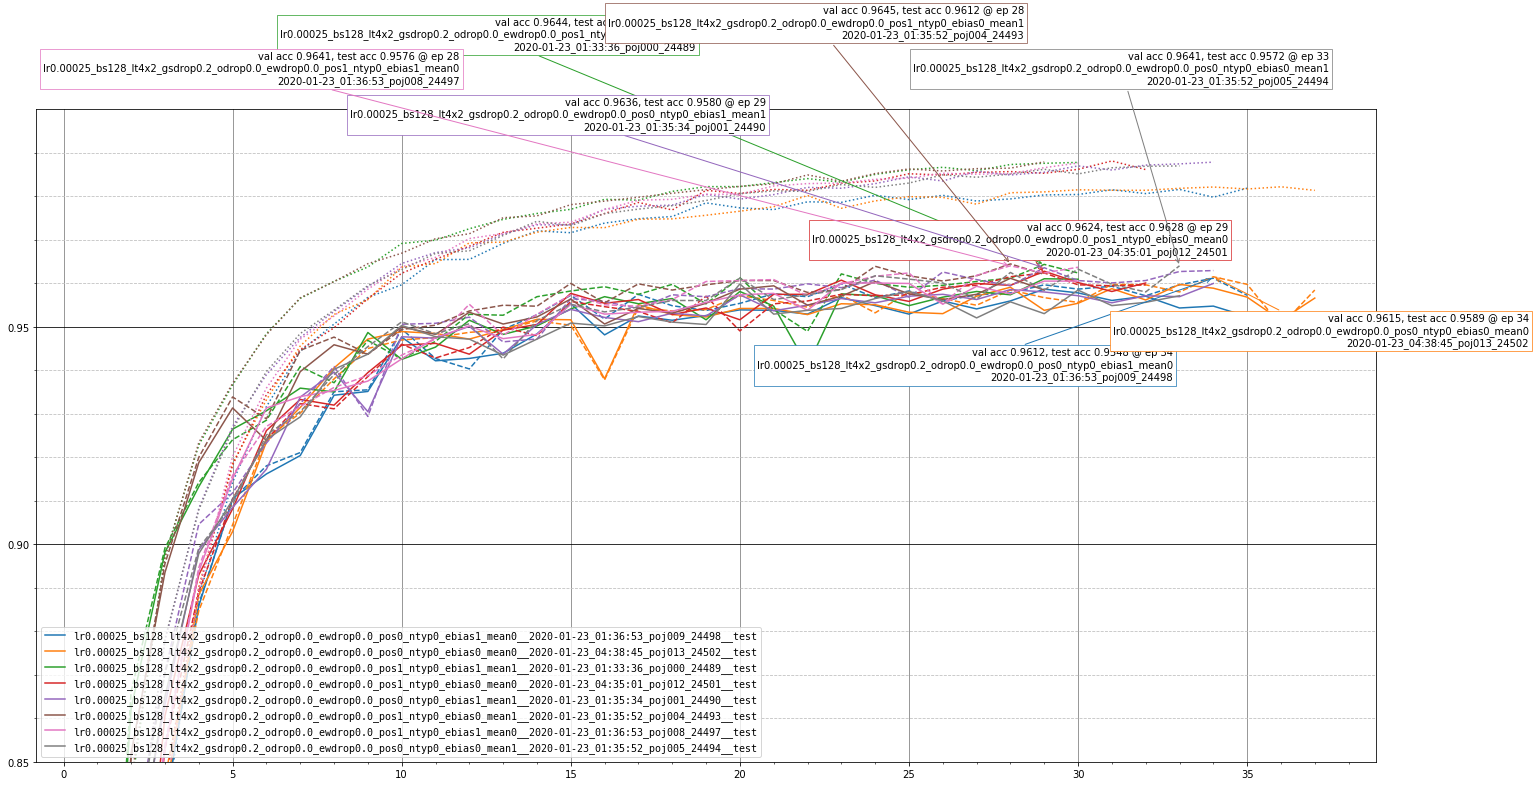

In [8]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
sub = 'ault_logs_mirror/run_over_binary_choices/'
#sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir)
plot_logs(logs, hyps)